In [3]:
import pandas as pd
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
from tqdm import tqdm
import warnings
import statsmodels.api as sm
import yfinance as yf
warnings.filterwarnings("ignore")
list_ = pd.read_csv("../database/tw_maincode_etf__2025.csv")
tw_etf_code_list = list_['code'].values
price = pd.read_parquet("../database/tw_price.parquet")
etf_price = price[price['code'].isin(tw_etf_code_list)]
# tester
# etf_price[etf_price['code'] == "0050 TT Equity"].sort_values(by='da')[['da', "cl"]].set_index("da").plot()

op_df = etf_price.pivot_table(index='da', columns="code", values='op')
hi_df = etf_price.pivot_table(index='da', columns="code", values='hi')
lo_df = etf_price.pivot_table(index='da', columns="code", values='lo')
cl_df = etf_price.pivot_table(index='da', columns="code", values='cl')
vol_df = etf_price.pivot_table(index='da', columns="code", values='vol')
to_df = etf_price.pivot_table(index='da', columns="code", values='turnover')
etf_price.columns

Index(['da', 'code', 'cl', 'hi', 'lo', 'op', 'adj', 'avg_cl', 'vol', 'vol_net',
       'avg_count', 'avg_count_net', 'trade_count', 'turnover'],
      dtype='object')

In [ ]:
class KMeans:
    def __init__(self, tol=1e-5):
        self.tol = tol
        
        
    def clustering(self, data):
        pass
    
    def convergence_test(self, new_centroids, centroids) -> bool:
        if len(new_centroids) != len(centroids):
            return False
        return np.all(np.linalg.norm(new_centroids - centroids, axis=1) <= self.tol)
    
    def convergence_test_raw(self, new_centroids, centroids):
        if len(new_centroids) != len(centroids):
            return False
        
        for i in range(len(new_centroids)):
            if np.any(abs(new_centroids[i] - centroids[i])) > self.tol:  # 若任一元素超過誤差範圍
                return False
    

In [218]:
pct_cl_df = cl_df[['0050 TT Equity']].pct_change()
pct_cl_df['tom'] = pct_cl_df.shift(1)
pct_cl_df = pct_cl_df.iloc[2:]


In [220]:
data = np.array(pct_cl_df)

In [179]:
def distances_k_means(point_diff, method='eucldiean'):
    if method == 'eucldiean':
        return np.sqrt(
            np.sum(
                (point_diff) ** 2)
        )
    elif method == 'norm':
        return np.linalg.norm(point_diff)
    else: return None;
    
def mahalanobis_distance(point_diff, mean_vector, covariance_vector):
    return (point_diff - mean_vector) @ np.linalg.inv(covariance_vector) @ np.linalg.matrix_transpose(point_diff - mean_vector)

def convergence_test(a, b, tol=1e-5):
    if len(a) != len(b):
        return False
    
    for i in range(len(a)):
        print(a[i], b[i])
        if np.any(abs(a[i] - b[i])) > tol:  # 若任一元素超過誤差範圍
            return False
    
    return True  # 所有元素都接近

K-Means 收斂於 Iteration 23


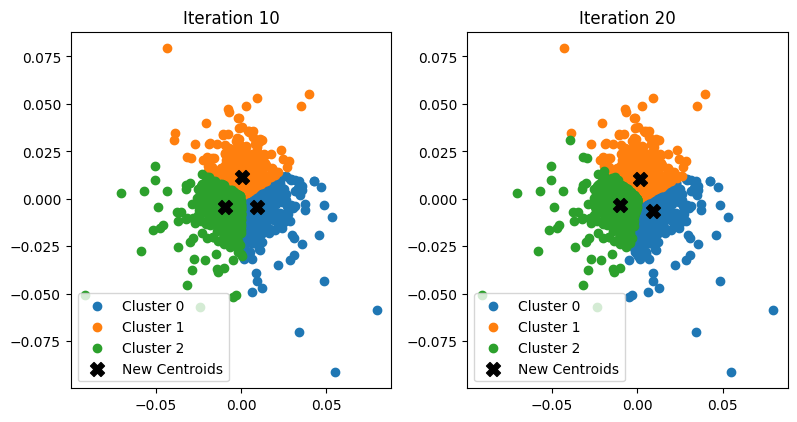

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import math


def compute_sse(clusters, centroids):
    """計算 SSE (Sum of Squared Errors)"""
    sse = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            sse += np.linalg.norm(point - centroids[i])**2
    return sse

def convergence_test(new_centroids, centroids, tol=1e-5):
    return np.all(np.linalg.norm(new_centroids - centroids, axis=1) <= tol)

K = 3
num_iterations = 100
plot_interval = 10  # Change this to control how often the plot is generated

centroids = data[np.random.choice(len(data), K, replace=False)]

# List to store centroids for each iteration
centroids_history = []
sse_list = []
# Calculate how many plots will be shown based on plot_interval
plots_to_show = math.ceil(num_iterations / plot_interval)

# Dynamically calculate the number of rows and columns based on plots_to_show
cols = math.ceil(math.sqrt(plots_to_show))  
rows = math.ceil(plots_to_show / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
axes = axes.flatten()  # Flatten the axes to make it easy to index

plot_counter = 0  # Counter to track how many plots we've made

for iteration in range(num_iterations):
    clusters = [[] for _ in range(K)]

    for point in data:
        distances = [distances_k_means(point - centroid) for centroid in centroids]
        cluster_index = np.argmin(distances)
        clusters[cluster_index].append(point)

    new_centroids = np.array([np.mean(cluster, axis=0) if cluster else centroids[i] 
                              for i, cluster in enumerate(clusters)])

    # Save the current centroids to centroids_history
    centroids_history.append(new_centroids)

    # Only plot every 'plot_interval' iterations
    if (iteration + 1) % plot_interval == 0:
        ax = axes[plot_counter]  # Get the next available axis to plot
        plot_counter += 1  # Increment the plot counter
        ax.set_title(f"Iteration {iteration + 1}")

        for i, cluster in enumerate(clusters):
            cluster_points = np.array(cluster)
            if len(cluster_points) > 0:
                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
        ax.scatter(new_centroids[:, 0], new_centroids[:, 1], c='black', marker='X', s=100, label='New Centroids')
        ax.legend()

    if convergence_test(new_centroids, centroids):
        print(f"K-Means 收斂於 Iteration {iteration+1}")
        break
    centroids = new_centroids  
    sse = compute_sse(clusters=clusters, centroids=centroids)
    sse_list.append(sse)
# Remove any remaining unused axes (in case plots_to_show is smaller than the total axes)
for i in range(plot_counter, len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()  
plt.show()

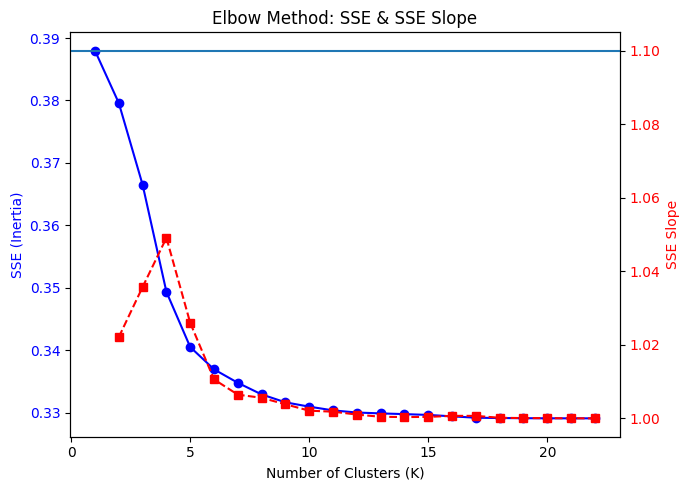

In [250]:
# 計算 SSE slope（下降率）
sse_slope = [sse_list[i] / sse_list[i+1] for i in range(len(sse_list) - 1)]

# 繪製 Elbow Method 圖
fig, ax1 = plt.subplots(figsize=(7, 5))

# **第一條曲線: SSE**
ax1.plot(np.arange(1, len(sse_list)+1), sse_list, marker='o', linestyle='-', color='b', label="SSE")
ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("SSE (Inertia)", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# **第二條曲線: SSE slope**
ax2 = ax1.twinx()
ax2.plot(np.arange(1, len(sse_list)+1)[1:], sse_slope, marker='s', linestyle='--', color='r', label="SSE Ratio")
ax2.set_ylabel("SSE Slope", color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.axhline(y=1.10)
# **標題與圖例**
plt.title("Elbow Method: SSE & SSE Slope")
fig.tight_layout()
plt.show()

In [287]:
transition[1, 2] =

np.float64(0.0)

In [295]:
df['diff'] = np.log(df['Close']/df['Open'])
def classify_data(x):
    if x > 0.01: return 1
    elif x < -0.01: return -1
    else: return 0
df['tag'] = df['diff'].apply(classify_data)

# transition_prob:
prev = -1
transition = np.zeros((3, 3), dtype=float)
for index, row in df[:242].iterrows():
    prev_state_row_index = prev + 1
    
    current_state_column_index = int(row['tag'] + 1)
    transition[prev_state_row_index, current_state_column_index] +=1 
    prev = int(row['tag'])

np.mean(transition)

array([[21., 26., 27.],
       [22., 36., 29.],
       [30., 25., 26.]])

In [314]:
mean_matrix = np.mean(transition, axis=1).reshape(-1, 1) 

k = (transition / mean_matrix)/ 3
k

array([[0.28378378, 0.35135135, 0.36486486],
       [0.25287356, 0.4137931 , 0.33333333],
       [0.37037037, 0.30864198, 0.32098765]])

[*********************100%***********************]  1 of 1 completed


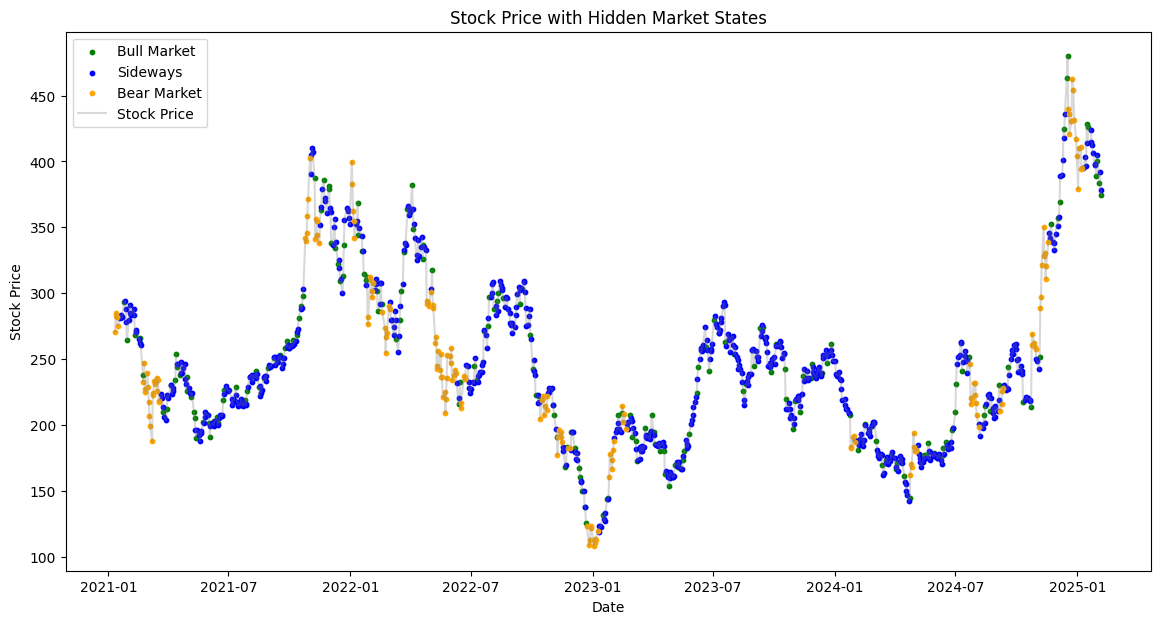

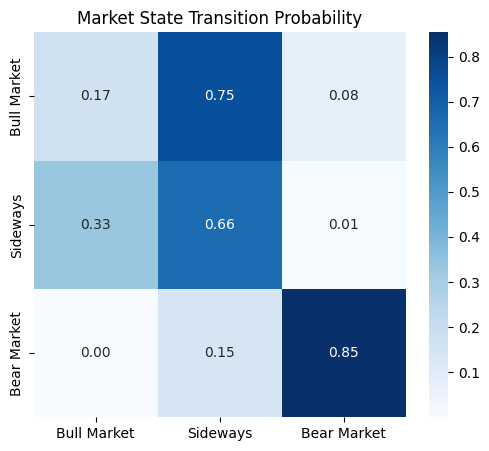

In [274]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

# 讀取股價數據
df = yf.download("TSLA", start='2021-01-01')  # 假設數據包含.index和 'Close' 欄位
df["return"] = df["Close"].pct_change()  # 計算日收益率
df.dropna(inplace=True)

# 建立 HMM 模型
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)

# 訓練模型
returns = df["return"].values.reshape(-1, 1)
df["volatility"] = df["return"].rolling(window=5).std()  # 5 日波動率
df["volume_change"] = df["Volume"].pct_change()  # 成交量變化
df.dropna(inplace=True)

# HMM 模型輸入特徵
features = df[["return", "volatility", "volume_change"]].values

# 設定 4 個市場狀態 (n_components=4)
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=200, random_state=42)
model.fit(features)

# 預測市場狀態
hidden_states = model.predict(features)
df["state"] = hidden_states

# 轉移機率矩陣
transition_matrix = model.transmat_

# 繪製股價與隱藏狀態
plt.figure(figsize=(14, 7))
colors = ["green", "blue", "orange", "red"]  # 牛市、震盪上行、震盪下行、熊市
labels = ["Bull Market", "Sideways", "Bear Market"]

for i in range(3):
    state_data = df[df["state"] == i]
    plt.scatter(state_data.index, state_data["Close"], color=colors[i], label=labels[i], s=10)

plt.plot(df.index, df["Close"], color="gray", alpha=0.3, label="Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price with Hidden Market States")
plt.show()

# 繪製轉移機率矩陣
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Market State Transition Probability")
plt.show()

In [261]:
# 模擬未來 10 天股價變化
future_returns, future_states = model.sample(10)

# 轉換為股價
future_prices = [df["Close"].iloc[-1]]
for ret in future_returns:
    future_prices.append(future_prices[-1] * (1 + ret[0]))

print("Predicted Future Prices:", future_prices)


Predicted Future Prices: [np.float64(82.33000183105469), np.float64(80.88852733602356), np.float64(81.30852566390834), np.float64(81.73568189523134), np.float64(83.10261517563542), np.float64(82.36974943313542), np.float64(81.63820661687808), np.float64(78.20397298124267), np.float64(79.4334173368268), np.float64(78.93157662517699), np.float64(77.94467311694518)]
